In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#import numba

In [2]:
df=pd.read_csv('../data/master_adv_id_quarterly.csv')

In [3]:
df.index=df.idadvertiser_master
df.drop(columns=['idadvertiser_master'], axis=1, inplace=True)

In [4]:
df.head()

,2009-Q1,2009-Q2,2009-Q3,2009-Q4,2010-Q1,2010-Q2,2010-Q3,2010-Q4,2011-Q1,2011-Q2,...,2016-Q3,2016-Q4,2017-Q1,2017-Q2,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4
idadvertiser_master,,,,,,,,,,,,,,,,,,,,,
14,542.471910,741.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
28,819.101124,1085.833333,1133.241758,1087.087912,1112.359551,1095.000000,1296.428571,1020.329670,1056.741573,916.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
40,977.528090,1533.333333,1961.538462,1483.516484,1870.786517,1900.000000,1895.604396,1862.637363,1825.842697,1277.777778,...,1384.615385,1373.626374,1258.426966,1188.888889,1461.538462,2867.802198,3706.516854,4432.0,3756.923077,1779.56044
43,758.426966,475.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
103,1303.370787,2422.222222,2395.604396,769.230769,1438.202247,3777.777778,4527.472527,5582.417582,5797.752809,5333.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000


In [5]:
def ma(array, window=1):  # Moving average
     return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

In [70]:
def get_periods(data_frame, mov_avg):

    my_df=data_frame
    ma_window=mov_avg
    
    #print(len(my_df.index))
    
    period=[]

    for i in range(0, len(my_df.index)):
        
        location=i

        time_series=np.array(my_df.iloc[location,:]).reshape(1,-1)
        time_series=time_series-ma(time_series, window=ma_window) # Remove the trend

            # Next largest power of 2        
        nfft=1<<(time_series.shape[1]-1).bit_length()

        y=np.fft.fft(time_series, n=nfft)
        y=abs(y**2)
        y=(y-y.min())
        y=y/y.max()

        freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
        #freq_ts=1/freq_ts
        #freq_ts=freq_ts[1:]
        freq_ts=freq_ts.reshape(-1,1)

        y=y[0][0:int(nfft/2)].reshape(1,-1).T

        period.append( (1/freq_ts[ np.argmax(y) ])[0] )
        
    return period

In [71]:
start_time = datetime.now()
my_periods=get_periods(df, 4)
end_time = datetime.now()
print('Execution time: {}'.format(end_time - start_time))

Execution time: 0:00:16.258013


In [69]:
my_periods

[4.76923076923077]

Period detected: 4.76923076923077


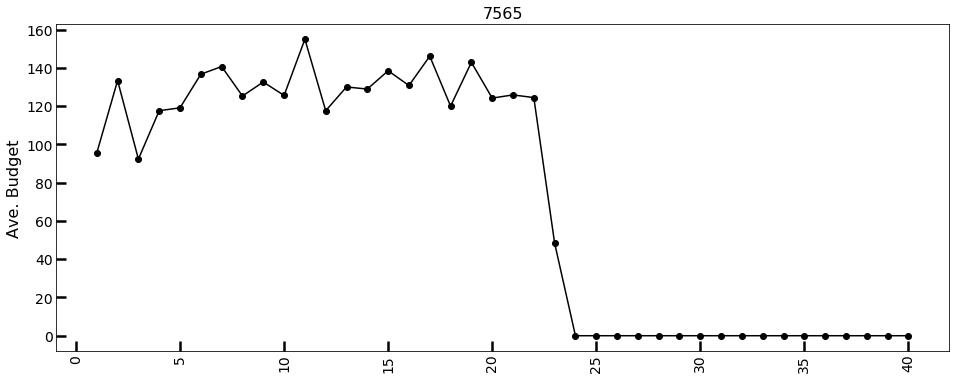

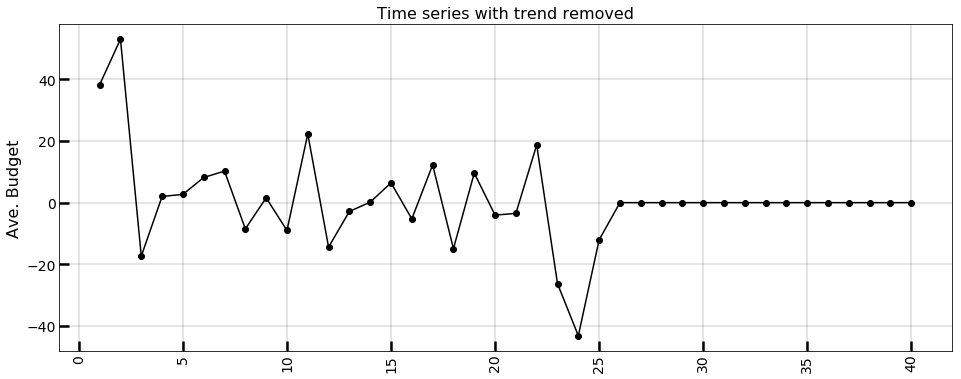

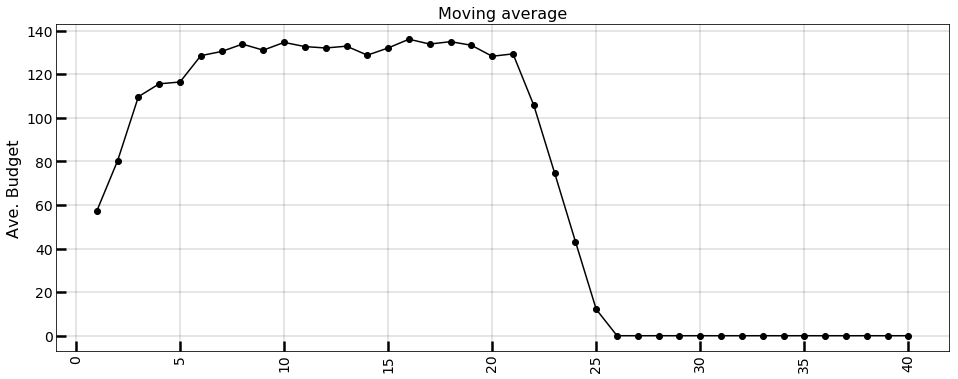

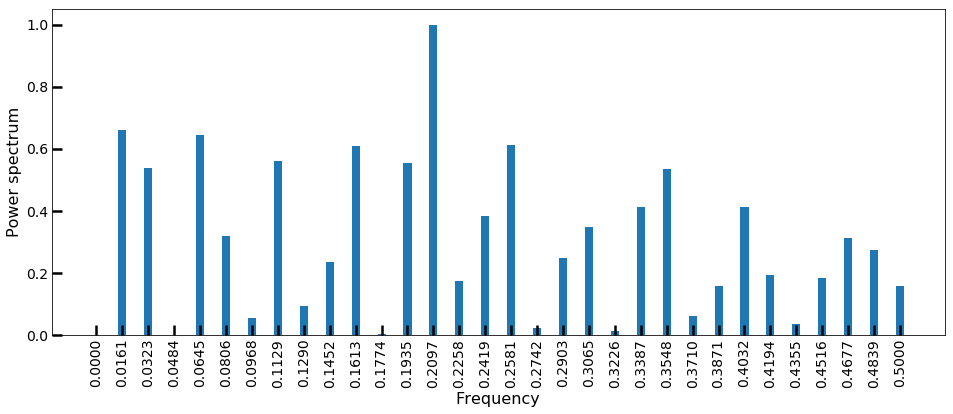

In [76]:
location=600

#print('Seasonality detected:', seasonal[location])
print('Period detected:', my_periods[location])

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,df.columns.shape[0]+1), df.iloc[location,:],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title(my_df.index[location], fontsize=16);

time_series=np.array(df.iloc[location,:]).reshape(1,-1)
mov_avg=ma(time_series, window=4)
time_series=time_series-ma(time_series, window=4)
nfft=1<<(time_series.shape[1]-1).bit_length()
freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
freq_ts=freq_ts.reshape(1,-1).T


# Perform FFT
y=np.fft.fft(time_series, n=nfft)
y=abs(y**2) # Get the power spectrum

# Scale (optional)
y=(y-y.min())
y=y/y.max()

# Reshaping because Python is stupid and doesn't take care of this 
# automatically. Boy I miss Matlab.
y=y[0][0:int(nfft/2)].reshape(1,-1).T

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,df.columns.shape[0]+1),time_series[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time series with trend removed', fontsize=16)
 

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,df.columns.shape[0]+1),mov_avg[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Moving average', fontsize=16)

plt.figure(figsize=(16,6))
plt.cla()
plt.bar(freq_ts.T[0],y.T[0], width=0.005)
plt.xticks(ticks=freq_ts.T[0], rotation='vertical');
#plt.yscale('log')
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Power spectrum', fontsize=16);
plt.xlabel('Frequency', fontsize=16);


#print( (1/freq_ts[ np.argmax(y) ])[0] )

In [40]:
y.T[0][1:]

array([0.05584628, 0.16143036, 0.31901593, 0.50432157, 0.68931949,
       0.84685034, 0.95493092, 1.        , 0.97857157, 0.89708422,
       0.77008189, 0.61716478, 0.45935138, 0.31555691, 0.19981532,
       0.11967598, 0.07593997, 0.06362508, 0.07382041, 0.09595608,
       0.11999025, 0.13809955, 0.14562155, 0.14119397, 0.1262177 ,
       0.10389862, 0.0781723 , 0.05278411, 0.03070141, 0.01390798,
       0.00350974])

In [43]:
freq_ts

array([[62.        ],
       [31.        ],
       [20.66666667],
       [15.5       ],
       [12.4       ],
       [10.33333333],
       [ 8.85714286],
       [ 7.75      ],
       [ 6.88888889],
       [ 6.2       ],
       [ 5.63636364],
       [ 5.16666667],
       [ 4.76923077],
       [ 4.42857143],
       [ 4.13333333],
       [ 3.875     ],
       [ 3.64705882],
       [ 3.44444444],
       [ 3.26315789],
       [ 3.1       ],
       [ 2.95238095],
       [ 2.81818182],
       [ 2.69565217],
       [ 2.58333333],
       [ 2.48      ],
       [ 2.38461538],
       [ 2.2962963 ],
       [ 2.21428571],
       [ 2.13793103],
       [ 2.06666667],
       [ 2.        ]])